# Lale and its Impact on the Data Science Workflow

Guillaume Baudart, Martin Hirzel, Kiran Kate, Pari Ram, and Avi Shinnar

27 March 2020

Examples, documentation, code: https://github.com/ibm/lale

<img src="../docs/img/lale_logo.jpg" alt="logo" width="140px" align="left"/>

## Value Proposition

- **target user**: data scientist familiar with Python and scikit-learn
- **scope**: data preparation and machine learning (including some DL)
- **value**: consistent for both manual machine learning and auto-ML

<img src="img/2019-1105-three-values.png" style="width:350px" align="left">

## Example Dataset

In [1]:
import lale.datasets
(train_X_all, train_y_all), (test_X, test_y) = lale.datasets.covtype_df(test_size=0.1)
print(f'shape train_X_all {train_X_all.shape}, test_X {test_X.shape}')

shape train_X_all (522910, 54), test_X (58102, 54)


In [2]:
import sklearn.model_selection
train_X, other_X, train_y, other_y = sklearn.model_selection.train_test_split(
    train_X_all, train_y_all, test_size=0.9)
print(f'shape train_X {train_X.shape}, other_X {other_X.shape}')

shape train_X (52291, 54), other_X (470619, 54)


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index),
           train_X], axis=1).tail(10)

,y,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
230281,1,2995.0,229.0,14.0,175.0,17.0,5610.0,198.0,252.0,189.0,2474.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,2,2589.0,11.0,14.0,216.0,11.0,1064.0,204.0,210.0,141.0,2430.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112272,2,2978.0,6.0,7.0,60.0,6.0,4924.0,211.0,226.0,152.0,4782.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289150,2,2631.0,26.0,16.0,234.0,63.0,497.0,211.0,204.0,125.0,1842.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292744,6,2488.0,216.0,10.0,0.0,0.0,1209.0,210.0,250.0,175.0,1243.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305060,2,3071.0,149.0,11.0,212.0,27.0,3318.0,235.0,239.0,134.0,607.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124830,2,2889.0,38.0,9.0,0.0,0.0,3194.0,221.0,221.0,135.0,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300018,2,2796.0,175.0,10.0,268.0,129.0,1343.0,226.0,246.0,151.0,765.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195222,1,3239.0,318.0,11.0,90.0,17.0,5731.0,190.0,230.0,179.0,782.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481848,2,3027.0,198.0,20.0,488.0,67.0,5517.0,210.0,253.0,169.0,782.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Manual Pipeline

In [4]:
from sklearn.decomposition import PCA
from xgboost import XGBClassifier as XGBoost
lale.wrap_imported_operators()

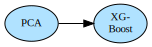

In [5]:
manual_trainable = PCA(n_components=6) >> XGBoost(n_estimators=3)
manual_trainable.visualize()

In [6]:
%%time
manual_trained = manual_trainable.fit(train_X, train_y)

CPU times: user 2.25 s, sys: 922 ms, total: 3.17 s
Wall time: 2.4 s


In [7]:
import sklearn.metrics
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')

accuracy 65.7%


## Hyperparameter Tuning

In [8]:
XGBoost.hyperparam_schema('n_estimators')

{'description': 'Number of trees to fit.',
 'type': 'integer',
 'default': 100,
 'minimumForOptimizer': 10,
 'maximumForOptimizer': 1500}

In [9]:
print(PCA.documentation_url())

https://lale.readthedocs.io/en/latest/modules/lale.lib.sklearn.pca.html


In [10]:
from lale.lib.lale import Hyperopt
import lale.schemas as schemas

CustomPCA = PCA.customize_schema(n_components=schemas.Int(min=2, max=54))
CustomXGBoost = XGBoost.customize_schema(n_estimators=schemas.Int(min=1, max=10))

hpo_planned = CustomPCA >> CustomXGBoost
hpo_trainable = Hyperopt(estimator=hpo_planned, max_evals=10, cv=3)

In [11]:
%%time
hpo_trained = hpo_trainable.fit(train_X, train_y)

100%|███████| 10/10 [01:48<00:00,  9.04s/trial, best loss: -0.7904606797855059]
CPU times: user 2min 4s, sys: 18 s, total: 2min 22s
Wall time: 1min 59s


### --- Excursions: Types as Search Spaces ---

<img src="img/2019-1208-loops.png" style="width:700px" align="left">

In [12]:
hpo_y = hpo_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, hpo_y):.1%}')

accuracy 80.4%


## Inspecting Automation Results

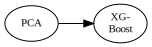

In [13]:
hpo_trained.get_pipeline().visualize()

In [14]:
hpo_trained.get_pipeline().pretty_print(ipython_display=True)

```python
from lale.lib.sklearn import PCA
from lale.lib.xgboost.xgb_classifier import XGBoost
import lale
lale.wrap_imported_operators()

pca = PCA(n_components=39, svd_solver='full')
xg_boost = XGBoost(colsample_bylevel=0.6016063807304212, colsample_bytree=0.7763972782064467, learning_rate=0.16389357351003786, max_depth=10, min_child_weight=5, n_estimators=5, reg_alpha=0.10485915855270356, reg_lambda=0.9268502695024392, subsample=0.4503841871781402)
pipeline = pca >> xg_boost
```

In [15]:
hpo_trained.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,-0.677267,2.413208,1.237615,ok
p1,1,-0.642768,1.940634,1.110030,ok
p2,2,-0.674858,4.282393,1.081256,ok
p3,3,-0.790461,8.183036,1.043846,ok
p4,4,-0.725881,5.782591,0.649556,ok
p5,5,-0.484959,2.385358,1.232421,ok
p6,6,-0.484959,1.795972,1.331217,ok
p7,7,-0.676503,2.803059,0.833762,ok
p8,8,-0.637509,2.076260,0.912490,ok


In [16]:
worst_name = hpo_trained.summary().loss.argmax()
print(worst_name)

p5


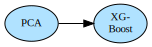

```python
pca = PCA(n_components=48, svd_solver='full', whiten=True)
xg_boost = XGBoost(booster='gblinear', colsample_bylevel=0.41777546097517426, colsample_bytree=0.6852556915729863, learning_rate=0.4299362917360751, max_depth=15, min_child_weight=18, n_estimators=7, reg_alpha=0.5266202371276923, reg_lambda=0.494226267796831, subsample=0.8015579071911012)
pipeline = pca >> xg_boost
```

In [17]:
hpo_trained.get_pipeline(worst_name).visualize()
hpo_trained.get_pipeline(worst_name).pretty_print(ipython_display=True, show_imports=False)

## Combined Algorithm Selection and Hyperparameter Tuning

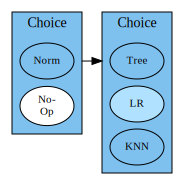

In [18]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import NoOp
lale.wrap_imported_operators()

KNN = KNN.customize_schema(n_neighbors=schemas.Int(min=1, max=10))
transp_planned = (Norm | NoOp) >> (Tree | LR(dual=False) | KNN)
transp_planned.visualize()

In [19]:
%%time
transp_trained = transp_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|█████████| 5/5 [02:37<00:00, 23.26s/trial, best loss: -0.8360329758332382]
CPU times: user 2min 28s, sys: 2.11 s, total: 2min 30s
Wall time: 2min 40s


### ---  Excursion: Bindings as Lifecycle ---

<img src="img/2019-1105-bindings.png" style="width:450px" align="left">

```python
knn = KNN(algorithm='ball_tree', metric='manhattan', n_neighbors=9)
pipeline = NoOp() >> knn
```

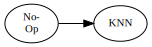

In [20]:
transp_trained.pretty_print(ipython_display=True, show_imports=False)
transp_trained.visualize()

In [21]:
%%time
transp_y = transp_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, transp_y):.1%}')

accuracy 86.8%
CPU times: user 1min 9s, sys: 297 ms, total: 1min 9s
Wall time: 1min 15s


## Non-Linear Pipeline

In [22]:
train_X.json_schema

{'type': 'array',
 'minItems': 52291,
 'maxItems': 52291,
 'items': {'type': 'array',
  'minItems': 54,
  'maxItems': 54,
  'items': [{'description': 'Elevation', 'type': 'number'},
   {'description': 'Aspect', 'type': 'number'},
   {'description': 'Slope', 'type': 'number'},
   {'description': 'Horizontal_Distance_To_Hydrology', 'type': 'number'},
   {'description': 'Vertical_Distance_To_Hydrology', 'type': 'number'},
   {'description': 'Horizontal_Distance_To_Roadways', 'type': 'number'},
   {'description': 'Hillshade_9am', 'type': 'number'},
   {'description': 'Hillshade_Noon', 'type': 'number'},
   {'description': 'Hillshade_3pm', 'type': 'number'},
   {'description': 'Horizontal_Distance_To_Fire_Points', 'type': 'number'},
   {'description': 'Wilderness_Area1', 'type': 'number'},
   {'description': 'Wilderness_Area2', 'type': 'number'},
   {'description': 'Wilderness_Area3', 'type': 'number'},
   {'description': 'Wilderness_Area4', 'type': 'number'},
   {'description': 'Soil_Type1

In [23]:
area_columns = [f'Wilderness_Area{i}' for i in range(1, 5)]
soil_columns = [f'Soil_Type{i}' for i in range(1, 41)]
binary_columns = area_columns + soil_columns
other_columns = [c for c in train_X.columns if c not in binary_columns]
print(f'other_columns == {other_columns}')

other_columns == ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


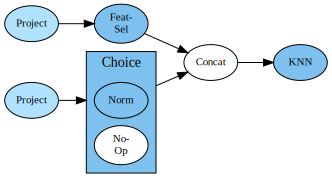

In [24]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Concat
from sklearn.feature_selection import SelectKBest as FeatSel
lale.wrap_imported_operators()

binary_prep = Project(columns=binary_columns) >> FeatSel
other_prep = Project(columns=other_columns) >> (Norm | NoOp)
nonlin_planned = (binary_prep & other_prep) >> Concat >> KNN
nonlin_planned.visualize()

In [25]:
%%time
nonlin_trained = nonlin_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|█████████| 5/5 [03:59<00:00, 39.02s/trial, best loss: -0.8598801963243338]
CPU times: user 3min 54s, sys: 781 ms, total: 3min 54s
Wall time: 4min 1s


### --- Excursion: Combinators ---

| Lale feature            | Name | Description  | Scikit-learn feature                |
| ----------------------- | ---- | ------------ | ----------------------------------- |
| >> or `make_pipeline`   | pipe | feed to next | `make_pipeline`                     |
| & or `make_union`       | and  | run both     | `make_union` or `ColumnTransformer` |
| &#x7c; or `make_choice` | or   | choose one   | N/A (specific to given AutoML tool) |

### --- Excursion: Interoperability ---

<img src="img/2019-1105-interop.png" style="width:550px" align="left">

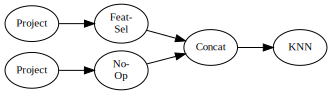

```python
project_0 = Project(columns=['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'])
feat_sel = FeatSel(k=8)
pipeline_0 = make_pipeline(project_0, feat_sel)
project_1 = Project(columns=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'])
pipeline_1 = make_pipeline(project_1, NoOp())
union = make_union(pipeline_0, pipeline_1)
knn = KNN(algorithm='kd_tree', n_neighbors=7, weights='distance')
pipeline = make_pipeline(union, knn)
```

In [26]:
nonlin_trained.visualize()
nonlin_trained.pretty_print(ipython_display=True, show_imports=False, combinators=False)

In [27]:
%%time
nonlin_y = nonlin_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, nonlin_y):.1%}')

accuracy 88.8%
CPU times: user 4.52 s, sys: 62.5 ms, total: 4.58 s
Wall time: 4.63 s


In [28]:
binary_prep_trainable = Project(columns=binary_columns) >> FeatSel(k=8)
binary_prep_trained = binary_prep_trainable.fit(train_X, train_y)
binary_prep_trained.transform(test_X.head(10))

,Wilderness_Area1,Wilderness_Area4,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type10,Soil_Type38,Soil_Type39
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Summary

- code and documentation: https://github.com/ibm/lale
- more examples: https://nbviewer.jupyter.org/github/IBM/lale/tree/master/examples/
- frequently asked questions: https://github.com/IBM/lale/blob/master/docs/faq.rst
- arXiv paper: https://arxiv.org/pdf/1906.03957.pdf

<img src="img/2019-1105-summary.png" style="width:350px" align="left">